# E-Menza - E-mail adatok betöltése Bert + LSTM + One Shot osztályozása

**Legfontosabb különbség a jelen 04b notebooknak a 04-eshez képest, hogy az LSTM réteg neuronjainak számát 16-ról 64-re növeltem.** A neuronhálózatoknál nagyon fontos a megfelelő reprezentáció kialakítása a belső rétegeken és a **"piramisszerű" egyenletes szűkítés** a bemenettől a kimenetig. A 04-es notebookban az LSTM 16 neuronja megegyezett az utána következő Dense réteg 16 neuronjával, ezért a betanításnál nagyon nehéz volt jó eredményt elérni mind a validációs, mind a betanító halmazon. A **64 neuron szélességűre növelt LSTM réteg** már a 2. betanításra **100%**-os eredményt produkált a betanító halmazon és **94%**-os eredményt a validációs halmazon, ahogy látható az alábbiakban.

Jelen notebook betölti a 01-es notebookban kimentett, előfeldogozott, az info@e-menza.hu postafiókban található beérkező e-maileket. Ezután betölti a magyar nyelvre betanított huBERT (https://hlt.bme.hu/en/resources/hubert) nyelvi modellt. Tokenizálja az adatokat és felépít a tokenizáló kimeneti adataira egy One Shot hálózatot, amely architektúrája az alábbi ábrán látható.

A jelenlegi **OSL** hálózat abban különbözik az előzőtől, hogy a duplán beágyazott belső modellben a **BERT** és a **sűrű(Dense)** réteg közé bekerült egy **LSTM réteg**.

A notebook végén a teljes adathalmazt önmagával összehasonlítom és közben a betanított hálózat **belső Lambda rétegének bemenetét kinyerem**. Így megkapom a hálózat által **megtanult reprezentációt**, amely egy **16 dimenziós térben** megmutatja az egyes e-mailek szemantikai elhelyezkedését (az egymáshoz hasonló értelmű e-mailek közel kerülnek egymáshoz a térben). Ezután **dimenzió redukciós eljárásokat** alkalmazok a teljes adathalmazra, hogy a 16 dimenziót 3 dimenzióra konvertáljam. Az Sklearn modul **TruncatedSVD** és **PCA** eljárásai **megőrzik a térbeli elhelyezkedést** miközben csökkentik a dimenziószámot. A 3 dimenziós vektorokat **3D interaktív grafikonon** ábrázolom. A színek az egyes kategóriákat jelölik. A 2 eljárás eredményét külön grafikonokon jelenítem meg. Látható, hogy a jelen betanítási eredményekkel most már **mindhárom adathalmaz élesen elkülönül** a 3 dimenziós térben is ellentétben a 04-es notebook eredményével.

Látható 2 db regisztrációs kód (piros pötty) probléma a jelszóval kapcsolatos e-mailek között (zöld pöttyök). Ezek gyanús helyen voltak, ezért az adatbázisból kikeresve listáztam a 2 levél tartalmát. Egyértelműen kiderült, hogy **rosszul kategorizáltak**, mert igazából az egyik levél nem illeszkedik egyetlen kategóriába sem, a másik levél pedig ténylegesen jelszó probléma. Az előzőt ki kell **törölni** a betanító halmazból, mert rontja az elérhető pontosságot, az utóbbit pedig **áttenni** a jelszó kategoriába. A 2 levél közül az elsőt megtaláltuk a 04-es notebookban is, de a másikat nem.

Megkerestem a 04-es notebookban felfedezett **ott nagyon különálló e-mailt** (piros pötty), ami valószínűleg azért került ennyire távol a piros+zöld alaphalmaztól, mert a levél rövid és az utána következő **angol nyelvű jogi szöveg** megzavarhatta az értelmezőt. Jelen notebook 3D grafikonján viszont nem különül el a többi piros pöttytől. Ettől függetlenül továbbra is érdemes a kezdeti adattisztításnál a levelek végéről levágni a hasonló reklámokat, jogi szövegeket.

A végső 1 neuronból álló sűrű (Dense) réteg szigmoid aktivációs függvénye azonban nem közvetlenül a Lambda réteg bemeneti reprezentációjából dolgozik, hanem a 2 tenzor egyes dimenziós értékeinek **súlyozott különbségéből**, mivel a Lambda rétegnek 16 kimenete 16 súllyal rendelkező kapcsolaton keresztül összegződik az utolsó réteg bemenetén. Ezért feltehető volt, hogy a betanítás alatt a hálózat megtanulja a 16 dimenzió közül **melyik fontosabb és melyik kevésbé az** és ennek megfelelően állítja be az utolsó 2 réteg közötti súlyokat. Ezért **kinyertem** ezt a 16 súlyt (weights) és az eltolást (bias), majd felszoroztam egyesével a Lambda réteg bemenetéről az előbbiekben már kinyert reprezentációs tenzor megfelelő értékeit és hozzáadtam az eltolást. Ez azért volt megthetető, mert a Lambda réteg egy matematikai műveletet hajt végre (**|t(0)-t(1)|**), amelyet szorozni kell a súlyokkal + eltolás (**|t(0)-t(1)| x w + b**) és a szorzás bevihető az abszolútértéken belülre (**|(t(0) x w + b) - (t(1) x w + b)|**). Ezután ezt a reprezentációt az előzőekben már alkalmazott **TruncatedSVD** és **PCA** eljárásokkal 3D interaktív grafikonokon ábrázoltam. Az eredmény nem mutat különbséget az előző ábrázoláshoz képest, így nem jutottam újabb eredményre. 

Megoldásra került a **modellek súlyainak mentése** és a **legjobb súlyhalmaz visszatöltése**.

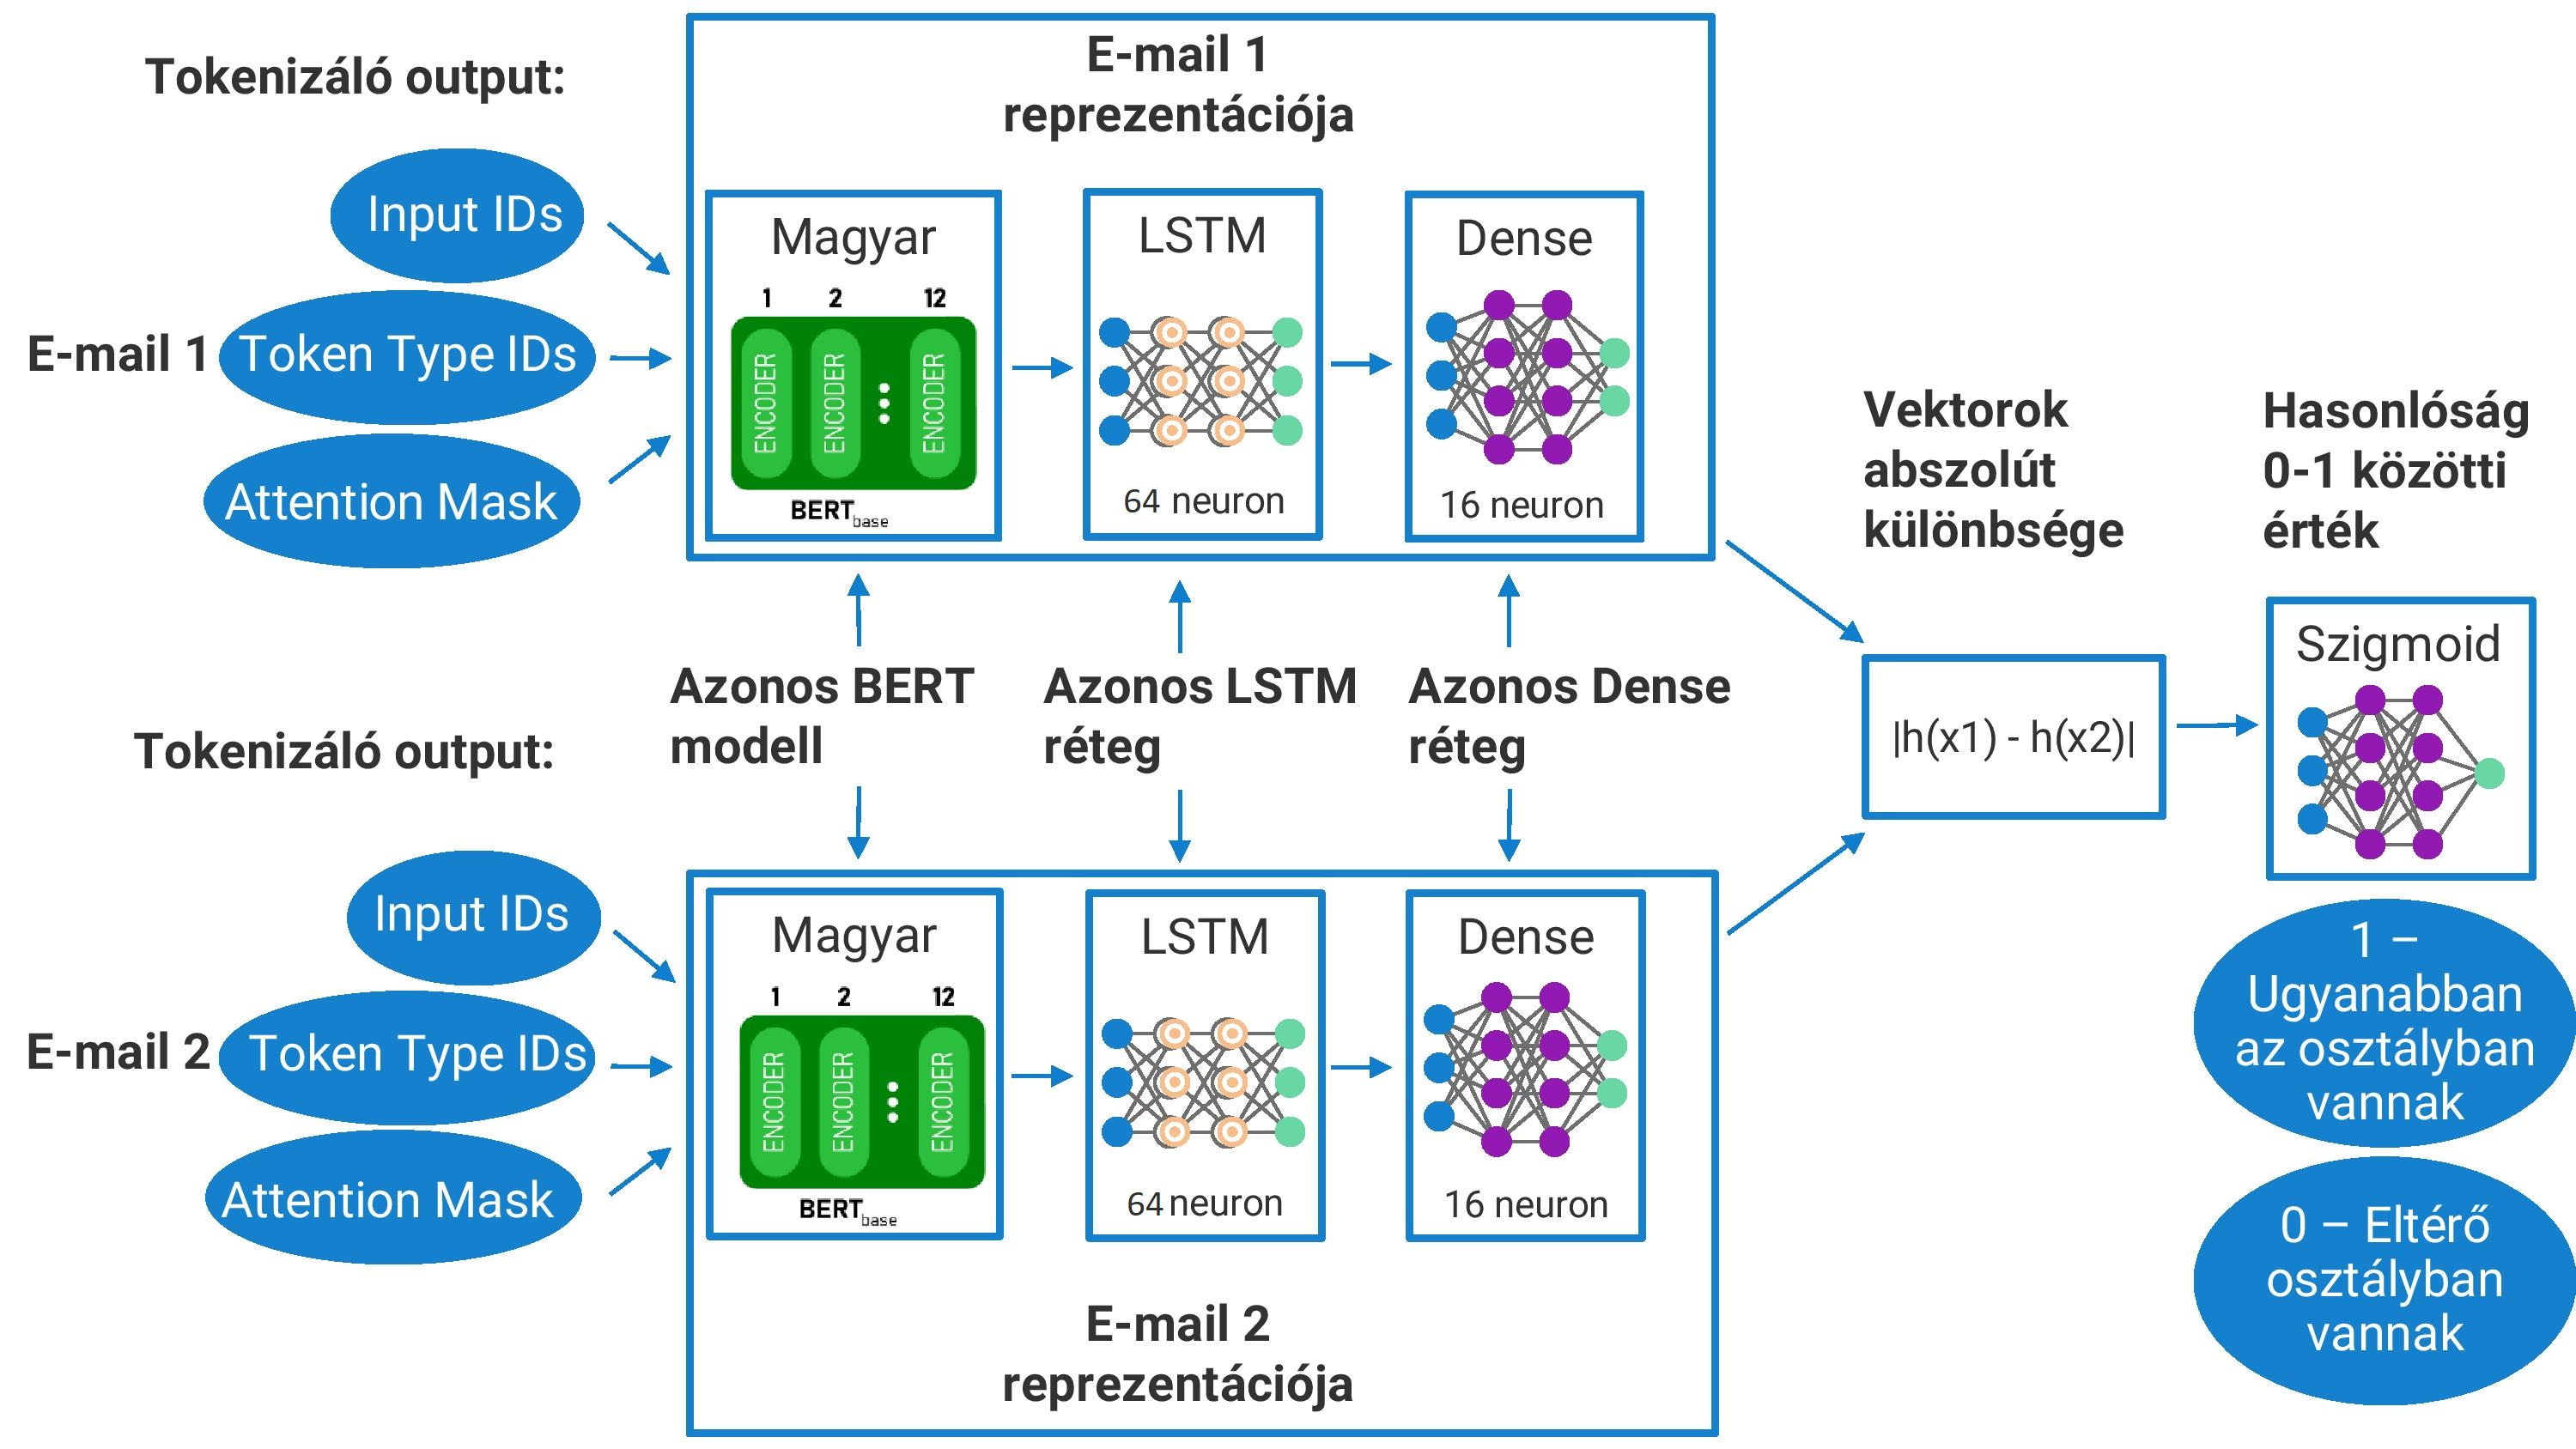

## BERT kategorizálás

A neurális hálózat betanításához szükséges a levelek kézi osztályozása, ezért készült egy BERT_kategoriak almappa, amely alatt jelenleg a mostani notebookban alkalmazott 3 címke található ugyancsak almappaként: 

* jelszó (mappanév: jelszo): a jelszóval, jelszóemlékeztetővel, belépési problémákkal kapcsolatos e-mailek;
* regisztrációs kód (mappanév: regkod): a gyerek szülőhöz rendeléséhez szükséges, az iskolai, óvodai adminisztrátor által kiküldött regisztrációs kód felhasználásával kapcsolatos problémák;
* utalás (mappanév: utaltam): az elutalt összegek feldolgozásával kapcsolatos egyenleg problémák.

Jelenleg 50 körüli e-mail található mindegyik kategóriában, de a számuk folyamatosan tovább bővül.

## Modulok importálása

Az alábbiakban importálom az adatok betöltéséhez, feldolgozásához szükséges modulokat.

* Az **os** az operációs rendszer fájlműveleteihez kell.
* A **numpy** matematikai műveletek gyors végrehajtását célozza.
* A **pandas** az adatok DataFrame adattáblába töltéséhez és módosításához szükséges.
* A **pickle** az adattáblák (DataFrame) fájlba mentéséhez.

* A **tensorflow, keras, transformers** modulok a neurális hálózatok építéséhez, a nyelvi elemző betöltéséhez szükségesek.

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import time
import pickle

import tensorflow as tf
import keras
import keras.layers as layers
from transformers import AutoTokenizer, TFAutoModel, BertTokenizer, TFBertModel, TFBertForSequenceClassification
from transformers.file_utils import PaddingStrategy
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

A kimentett, előfeldolgozott e-mail adatok betöltése.

In [2]:
df=pd.read_pickle("result/01_e-menza_emails.pkl")
df

from  \
0         Aniko *****    
1                                    Alexandra *****   
2                             Szőkéné *****   
3               Andras *****   
4                                          Beáta *****   
..                                                 ...   
148            Krisztina *****   
149                       Annamária *****   
150                                      József *****   
151                           emese.*****@t-online.hu   
152  Izabella *****   

                                               subject  \
0    Re: Menzakártya - Figyelmeztetés elmaradt menz...   
1                                                        
2           Re: Menzakártya - Rendelés visszaigazolása   
3    Fwd: Menzakártya - Figyelmeztetés elmaradt men...   
4                  Re: Menzakártya - Regisztrációs kód   
..                                                 ...   
148                                            Belépés   
149  Re: Menzakártya - Figyelmeztetés elmaradt menz...   
150         Re: Menzakártya - Rendelés visszaigazolása   
151                                  belépési probléma   
152               Re: Menzakártya - Jelszó emlékeztető   

                                                  body category  
0    Szia Erika, Ezt az összeget nemrég elutaltam (...      1.0  
1    Tisztelt Cím!\r\nNem tudom megrendelni gyermek...      2.0  
2    Tisztelt cím ! 2020.szeptember 04-én a fenti b...      1.0  
3    Tisztelt Hölgyem/Uram!, Köszönjük az emlékezte...      1.0  
4    Tisztelt Cím! Kislányom neve ***** Anna *****...      3.0  
..                                                 ...      ...  
148  Továbbra sem tudok belépni, regisztráltam már....      2.0  
149  Elnézést kérek az elmaradásért. Ma reggel utal...      1.0  
150  Kedves Menza! Elnézést kérek, most tűnt fel ne...      1.0  
151  Tisztelt Üzemeltető,\r\n\r\nKérem szíves tájék...      2.0  
152  Tisztelt Menzakartya mas jelszót ,adtammég és ...      2.0  

[153 rows x 4 columns]

## Neurális hálózat felépítése, betanítása

Először definiálom a hálózat legfontosabb paramétereit:

* maximum_msg_size = 64 : Maximum az első 64 tokent veszem figyelembe, ami a jelenlegi tapasztalatok alapján elegendő, de később még növelhetem ezt az értéket.
* A súlyok és az eltolás(bias) értékét a belső Dense rétegnél speciálisan inicializálom a http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf tanulmány alapján.
* Egy külön segédfüggvényben építem fel a bevezetőben szereplő ábrán látható hálózatot.
* A beágyazott Bert modell után egy reprezentációt szűkítő 64 neuronból álló LSTM, majd egy 16 neuronból álló Dense réteg került.
* result_labels_size = 3 : A kimeneti kategóriák száma
* test_size = 0.1 : A teszt halmaz mérete.

Ezután betöltöm az előre betanított nyelvi tokenizálót és modellt. Tokenizálom az adattábla legelső mondatát példaképpen, hogy milyen kimenetre számíthatok. A következő részben összeszerelem a neurális hálózat 3 bemeneti rétegét: input_ids, type_ids, attention_mask_ids. Szétbontom az adatokat betanító és teszt halmazokra.

Ezután a get_batch függvény segítségével olyan batch_size(=16) méretű párokat építek össze véletlenszerűen a betanítóhalmazból kiválasztva, amelyek első fele (0-7 elemek) nem egyezik, azaz különböző osztályból valók (targets = 0) és a 2. fele (8-15. elemek) már ugyanabból az osztályból származik (targets =1), de itt is véletlenszerűen.

Felépítem és lefordítom a neurális hálózatot.  Ezután lefuttatom a betanítást. Végeredményként 90%+-os validációs pontosságot kaptam.

In [3]:
def initialize_weights(shape, dtype=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [4]:
def initialize_bias(shape, dtype=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [5]:
def get_siamese_model():
    
    # Hungarian BERT network
    input_ids = layers.Input(shape=(maximum_msg_size,), dtype=tf.int32, name="input_ids")
    token_type_ids = layers.Input(shape=(maximum_msg_size,), dtype=tf.int32, name="token_type_ids")
    attention_mask = layers.Input(shape=(maximum_msg_size,), dtype=tf.int32, name="attention_mask")
    
    embedding = embeddingmodel.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    lstm = layers.LSTM(64)(embedding)
    bert_flatten = layers.Flatten()(lstm)
    bert_dense = layers.Dense(16, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)(bert_flatten)

    model = keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[bert_dense])

    # Generate the encodings (feature vectors) for the two messages
    left_input_ids = layers.Input(shape=(maximum_msg_size,), dtype=tf.int32)
    left_token_type_ids = layers.Input(shape=(maximum_msg_size,), dtype=tf.int32)
    left_attention_mask = layers.Input(shape=(maximum_msg_size,), dtype=tf.int32)
    
    right_input_ids = layers.Input(shape=(maximum_msg_size,), dtype=tf.int32)
    right_token_type_ids = layers.Input(shape=(maximum_msg_size,), dtype=tf.int32)
    right_attention_mask = layers.Input(shape=(maximum_msg_size,), dtype=tf.int32)
    
    left_input = [left_input_ids, left_token_type_ids, left_attention_mask]
    right_input  = [right_input_ids, right_token_type_ids, right_attention_mask]
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = layers.Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = keras.Model(inputs=[left_input, right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [6]:
maximum_msg_size = 64
language_model = "SZTAKI-HLT/hubert-base-cc"
result_labels_size = 3
test_size = 0.1

In [7]:
tokenizer = AutoTokenizer.from_pretrained(language_model)
embeddingmodel = TFAutoModel.from_pretrained(language_model)
embeddingmodel.trainable = False

Some layers from the model checkpoint at SZTAKI-HLT/hubert-base-cc were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at SZTAKI-HLT/hubert-base-cc.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [8]:
tokenizer(str(df.loc[0,["body"]]))

{'input_ids': [2, 2046, 21750, 15689, 17751, 3576, 3848, 2033, 9819, 8790, 2052, 8532, 2669, 2125, 4575, 4575, 4575, 6088, 7345, 3282, 3407, 3576, 2090, 24485, 9518, 3282, 8894, 12167, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [9]:
model = get_siamese_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64)]         0           []                               
                                                                                            

In [10]:
optimizer = Adam(learning_rate = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])

In [11]:
sentences=df['body']
labels=df['category']

input_ids=[]
token_type_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=tokenizer.encode_plus(sent,add_special_tokens = True,max_length = maximum_msg_size,pad_to_max_length = True,
                                        return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    token_type_ids.append(bert_inp['token_type_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
token_type_ids=np.asarray(token_type_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Python310\lib\site-packages\transformers\tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
train_inp, val_inp, train_type_ids, val_type_ids, train_label,val_label,train_mask,val_mask=train_test_split(input_ids,
                                                                                                             token_type_ids,
                                                                                                             labels,
                                                                                                             attention_masks,
                                                                                                             test_size=test_size)

In [13]:
print("Train, test labels shape:", train_label.shape, val_label.shape)
print("Train, test input shape:", train_inp.shape, val_inp.shape, train_type_ids.shape, val_type_ids.shape, 
      train_mask.shape, val_mask.shape)

Train, test labels shape: (137,) (16,)
Train, test input shape: (137, 64) (16, 64) (137, 64) (16, 64) (137, 64) (16, 64)


In [14]:
def get_batch(batch_size,X_inp,X_type_ids,X_mask,X_label):
    
    labels_unique = np.unique(X_label)
    categories = np.random.choice(labels_unique,size=batch_size, replace=True)

    left_input_ids = np.zeros((batch_size, maximum_msg_size))
    left_token_type_ids = np.zeros((batch_size, maximum_msg_size))
    left_attention_mask = np.zeros((batch_size, maximum_msg_size))

    right_input_ids = np.zeros((batch_size, maximum_msg_size))
    right_token_type_ids = np.zeros((batch_size, maximum_msg_size))
    right_attention_mask = np.zeros((batch_size, maximum_msg_size))

    targets=np.zeros(batch_size)
    targets[batch_size//2:] = 1

    for i in range(batch_size):
        category = categories[i]
        idx_1 = np.random.choice(np.array(np.where(X_label == category)).flatten(), size=1)[0]
        left_input_ids[i] = X_inp[idx_1]
        left_token_type_ids[i] = X_type_ids[idx_1]
        left_attention_mask[i] = X_mask[idx_1]

        if i >= batch_size // 2:
            category_2 = category  
        else: 
            category_2 = np.random.choice(labels_unique[np.where(labels_unique != category)], size=1)[0]

        idx_2 = np.random.choice(np.array(np.where(X_label == category_2)).flatten(), size=1)[0]
        right_input_ids[i] = X_inp[idx_2]
        right_token_type_ids[i] = X_type_ids[idx_2]
        right_attention_mask[i] = X_mask[idx_2]
    
    return left_input_ids, left_token_type_ids, left_attention_mask, right_input_ids, right_token_type_ids, right_attention_mask, targets

Minden 200. futtatásnál kiértékelem az elkülönített teszthalmazon (validation) a hálózatot. Itt a validációs pontosságot (accuracy) kell figyelni. 1000 iteráción megyek végig és a batch méret 16.

In [15]:
evaluate_every = 200
batch_size = 16
n_iter = 1000
best = -1
iter_best = -1

A model_path definiálja a mappát, amelybe az összes súlyfájl mentésre kerül. **A könyvtárat előre kézzel létre kell hozni.**
A file_name a legjobb, azaz a vissszatöltésre kerülő súlyfájl neve.

In [16]:
model_path = './result/siamise_bert_lstm/'
file_name = 'weights.best.h5'

Kimentjük a betanításhoz használt halmazokat és a validációs halmazokat is a kategorizálással együtt.

In [17]:
np.save(os.path.join(model_path, "04b_train_inp.sav"), train_inp)
np.save(os.path.join(model_path, "04b_val_inp.sav"), val_inp)
np.save(os.path.join(model_path, "04b_train_type_ids.sav"), train_type_ids)
np.save(os.path.join(model_path, "04b_val_type_ids.sav"), val_type_ids)
np.save(os.path.join(model_path, "04b_train_label.sav"), train_label)
np.save(os.path.join(model_path, "04b_val_label.sav"), val_label)
np.save(os.path.join(model_path, "04b_train_mask.sav"), train_mask)
np.save(os.path.join(model_path, "04b_val_mask.sav"), val_mask)

A load_saved_model segédváltozó alapesetben hamis, hogy a neurális hálózat betanítása megtörténhessen. Ha igazra állítom és létezik lementett modell súlyfájl, akkor az kerül visszatöltésre és nem történik betanítás.

In [18]:
load_saved_model = False

if (os.path.exists(os.path.join(model_path, file_name)) and load_saved_model):
    print("Load weights of the best model from file:", file_name)
    model.load_weights(os.path.join(model_path, file_name))
else:
    if (os.path.exists(os.path.join(model_path, file_name))):
        os.remove(os.path.join(model_path, file_name))
        
    print("Starting training process!")
    print("-------------------------------------")
    t_start = time.time()
    for i in range(1, n_iter+1):
        #(inputs,targets) = get_batch(batch_size)
        l_inp, l_tok, l_mask, r_inp, r_tok, r_mask, targets = get_batch(batch_size,train_inp,train_type_ids,train_mask,train_label)
        loss = model.train_on_batch([[l_inp, l_tok, l_mask], [r_inp, r_tok, r_mask]], targets)
        if i % evaluate_every == 0:
            print("\n ------------- \n")
            print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
            print("Train loss, accuracy: {0}".format(loss)) 
            #val_acc = test_oneshot(model, N_way, n_val, verbose=True)
            l_inp, l_tok, l_mask, r_inp, r_tok, r_mask, targets = get_batch(batch_size,val_inp,val_type_ids,val_mask,val_label)
            results = model.evaluate([[l_inp, l_tok, l_mask], [r_inp, r_tok, r_mask]], targets)
            model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
            if results[1] >= best:
                print("Current best: {0}, previous best: {1}".format(results[1], best))
                best = results[1]
                iter_best = i
    
    os.rename(os.path.join(model_path, 'weights.{}.h5'.format(iter_best)), os.path.join(model_path, file_name))

Starting training process!
-------------------------------------

 ------------- 

Time for 200 iterations: 0.5421173810958863 mins
Train loss, accuracy: [0.7050111889839172, 0.5]
1/1 [==============================] - 5s 5s/step - loss: 0.7028 - accuracy: 0.5000
Current best: 0.5, previous best: -1

 ------------- 

Time for 400 iterations: 0.9946908195813496 mins
Train loss, accuracy: [0.6452355980873108, 0.625]
1/1 [==============================] - 0s 109ms/step - loss: 0.6178 - accuracy: 0.6875
Current best: 0.6875, previous best: 0.5

 ------------- 

Time for 600 iterations: 1.3692895611127218 mins
Train loss, accuracy: [0.4569564163684845, 1.0]
1/1 [==============================] - 0s 113ms/step - loss: 0.5275 - accuracy: 0.8125
Current best: 0.8125, previous best: 0.6875

 ------------- 

Time for 800 iterations: 1.7454011162122092 mins
Train loss, accuracy: [0.37085795402526855, 1.0]
1/1 [==============================] - 0s 111ms/step - loss: 0.4573 - accuracy: 0.8750
Curre

A meglévő, betanított modell belső rétegének inputját próbálom elérni, hogy kinyerjem a reprezentációt, amelyet a hálózat megtanult.

In [19]:
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer("lambda").input)

A teljes adathalmazt önmagával hasonlítom össze a 16 dimenziós reprezentáció kinyeréséhez. Mivel a beágyazott 2 hálózat ugyanaz, ezért a Lambda réteg bármelyik bemeneti vektorát használhatom.

In [20]:
intermediate_input = intermediate_layer_model([[input_ids,token_type_ids,attention_masks], 
                                               [input_ids,token_type_ids,attention_masks]])
intermediate_input

[<tf.Tensor: shape=(153, 16), dtype=float32, numpy=
 array([[0.91217625, 0.9150667 , 0.14889437, ..., 0.1500011 , 0.9181854 ,
         0.16112201],
        [0.15823561, 0.17481478, 0.9156118 , ..., 0.9151238 , 0.16158314,
         0.91059786],
        [0.9063251 , 0.9101125 , 0.1577866 , ..., 0.1593832 , 0.91427976,
         0.17041825],
        ...,
        [0.91176045, 0.9146249 , 0.1499336 , ..., 0.15170586, 0.91766644,
         0.162182  ],
        [0.17669341, 0.18097791, 0.9106468 , ..., 0.90611637, 0.17166322,
         0.90160036],
        [0.18892126, 0.19671181, 0.90212125, ..., 0.895589  , 0.18978027,
         0.8901536 ]], dtype=float32)>,
 <tf.Tensor: shape=(153, 16), dtype=float32, numpy=
 array([[0.91217625, 0.9150667 , 0.14889437, ..., 0.1500011 , 0.9181854 ,
         0.16112201],
        [0.15823561, 0.17481478, 0.9156118 , ..., 0.9151238 , 0.16158314,
         0.91059786],
        [0.9063251 , 0.9101125 , 0.1577866 , ..., 0.1593832 , 0.91427976,
         0.17041825],
 

In [21]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

A TruncatedSVD egy **dimenzió redukciós eljárás**, amely **megőrzi a térbeli távolságokat** az egyes elemek között miközben csökkenti a dimenziók számát. A 16 dimenzióból 3 dimenziót készítek. A sorok sorrendjét az eljárás nem változtatja meg, így építhetek arra, hogy ugyanolyan sorrendben következnek az elemek mint az eredeti adattáblában (DataFrame).


In [22]:
tsvd = TruncatedSVD(n_components=3)

intermediate_input_truncated = tsvd.fit_transform(intermediate_input[0])
intermediate_input_truncated[0:5]


array([[ 2.2195857 ,  1.3468581 , -0.0336197 ],
       [ 2.2614377 , -1.2631469 , -0.06034042],
       [ 2.2258472 ,  1.3226006 , -0.02895605],
       [ 2.2226443 ,  1.3347077 , -0.03072111],
       [ 2.3946211 , -0.06353597,  0.06380869]], dtype=float32)

In [23]:
intermediate_input_truncated.shape

(153, 3)

Mivel a **sorok sorrendjét megőrzi**, ezért az eredeti adattáblából egyszerűen hozzáragasztom a kategóriát jelző oszlopot, amelynek számértékeit kicserélem a kategória nevével az ábrázolás miatt.

In [24]:
df_rep = pd.DataFrame(intermediate_input_truncated)
df_rep["category"] = df.category
df_rep["category"] = df_rep["category"].replace([1.0,2.0,3.0],["Utalás","Regisztrációs kód","Jelszó"])
df_rep.columns = ["x","y","z","category"]
df_rep

x         y         z           category
0    2.219586  1.346858 -0.033620             Utalás
1    2.261438 -1.263147 -0.060340  Regisztrációs kód
2    2.225847  1.322601 -0.028956             Utalás
3    2.222644  1.334708 -0.030721             Utalás
4    2.394621 -0.063536  0.063809             Jelszó
..        ...       ...       ...                ...
148  2.266746 -1.227082 -0.043236  Regisztrációs kód
149  2.220943  1.342041 -0.032998             Utalás
150  2.220269  1.343887 -0.031363             Utalás
151  2.260145 -1.230323 -0.036595  Regisztrációs kód
152  2.267544 -1.186039 -0.028276  Regisztrációs kód

[153 rows x 4 columns]

## Interaktív, 3D grafikon ábrázolás

A 3 dimenziós vektorokat **3D interaktív grafikonon** ábrázolom. A színek az egyes kategóriákat jelölik. A 2 eljárás eredményét külön grafikonokon jelenítem meg. Látható, hogy a jelen betanítási eredményekkel most már **mindhárom adathalmaz élesen elkülönül** a 3 dimenziós térben is ellentétben a 04-es notebook eredményével.

Látható 2 db regisztrációs kód (piros pötty) probléma a jelszóval kapcsolatos e-mailek között (zöld pöttyök). Ezek gyanús helyen voltak, ezért az adatbázisból kikeresve listáztam a 2 levél tartalmát. Egyértelműen kiderült, hogy **rosszul kategorizáltak**, mert igazából az egyik levél nem illeszkedik egyetlen kategóriába sem, a másik levél pedig ténylegesen jelszó probléma. Az előzőt ki kell **törölni** a betanító halmazból, mert rontja az elérhető pontosságot, az utóbbit pedig **áttenni** a jelszó kategoriába. A 2 levél közül az elsőt megtaláltuk a 04-es notebookban is, de a másikat nem.

Megkerestem a 04-es notebookban felfedezett **ott nagyon különálló e-mailt** (piros pötty), ami valószínűleg azért került ennyire távol a piros+zöld alaphalmaztól, mert a levél rövid és az utána következő **angol nyelvű jogi szöveg** megzavarhatta az értelmezőt. Jelen notebook 3D grafikonján viszont nem különül el a többi piros pöttytől. Ettől függetlenül továbbra is érdemes a kezdeti adattisztításnál a levelek végéről levágni a hasonló reklámokat, jogi szövegeket.

In [25]:
import plotly.express as px

#1 - utaltam, 2 - regkod, 3 - jelszó
fig = px.scatter_3d(df_rep, x="x", y="y", z="z",color='category', template="plotly_white", width=900, height=700)
fig.show()

In [26]:
df_rep.loc[np.round(df_rep["x"], decimals = 6) == 2.38944] 

x        y        z           category
63  2.38944 -0.36032  0.05442  Regisztrációs kód

Látható, hogy ez az e-mail **rossz kategóriába** került. Igazából egyik kategóriába sem tartozik, ezért **törölni kell a betanító halmazból**. Ezt az e-mailt megtaláltuk a 04-es notebookban is.

In [27]:
print(df.iloc[63, 2])

Kedves ***** Judit, a segítségét szeretném kérni, lányunk ***** *****
***** étkezését illetően. 17.615 Ft tartozásról kaptunk értesítést úgy, hogy
***** összesen 4X evett az iskolában, azóta, hogy telefonon konzultálva
elindítottunk az ebédrendelését a Városmajori Gimnáziumban. Két dolgot
szeretnék kérni, \- a rendelés azonnali leállítását, mivel az edzésidőpontok
átrendezése miatt egyáltalán nem tud már az iskolában enni,- az el nem
fogyasztott ebédek kifizetésének eltekintését (azt hittük, hogy a megrendelés
addig tart, amíg ***** bejelölte, hogy melyik nap, melyik menüt szeretné
kérni) Köszönettel, Márta ***** \----- Forwarded Message -----
From: Menzakártya  To: marta.*****@*****.com Sent: Tuesday, April 5, 2016
9:17 PM Subject: Menzakártya - Menzakártya - új jelszó kérése #yiv4441250210
body {padding-right:5px;padding-left:5px;padding-
bottom:5px;margin:0px;padding-top:5px;font-family:arial, sans-serif;font-
size:12px;}#yiv4441250210 p {margin:0px;} | Jelszó emlékeztető www.e-menz

In [28]:
df_rep.loc[np.round(df_rep["x"], decimals = 5) == 2.39759] 

x         y         z           category
129  2.397587 -0.146459  0.061097  Regisztrációs kód

Ezt az e-mailt nem találtam meg a 04-es notebookban, de itt rögtön látható a 3D interaktív grafikonon. Az alábbi levél tartalma alapján **rossz kategóriába** került, **át kell tenni** a jelszó problémák közé.

In [29]:
print(df.iloc[129,2])

Sajnos így sem sikerül azt írja ki hogy hibás e mail cím vagy jelszó Izabella
*****  ezt írta (időpont: 2019. szept. 10., K 9:58): > Köszönöm még próbálom
akkor újra > > e-Menza Informatikai Ügyfélszolgálat  ezt írta (időpont: >
2019. szept. 10., K 9:57): > >> Nem szükséges újból regisztrálni! A
Bejelentkezés felirat alatti első >> mezőbe elég beírni az email címét
(*****@gmail.com), és alá a >> hozzá tartozó, saját maga által
választott jelszavát, ekkor megtörténik a >> bejelentkezés, és tud rendelni az
Étkezés megrendelése gombbal. >> >> Az egyszer használatos regisztrációs kódot
nem küldöm újból, mert arra a >> rendeléshez nincs szüksége. >> >>
Üdvözlettel, >> e-Menza Informatikai Ügyfélszolgálat >> info@e-menza.hu >> >>
------------------------------ >> *Feladó: *"Izabella *****"  >> *Címzett:
*"e-Menza Informatikai Ügyfélszolgálat"  >> *Elküldött üzenetek: *Kedd, 2019.
szeptember 10. 9:49:34 >> *Tárgy: *Re: Menzakártya - Emlékeztető: Nem rendelt
a következő hónapra >> >> Mobil tel

Megkerestem a 04-es notebookban felfedezett 44-es e-mailt is. Itt a piros halmaz szélén helyezkedik el, de nem különül el láthatóan a teljes piros halmaztól. Tehát itt nem fedeztem volna fel. Továbbra is igaz az, hogy a levél rövid és az utána következő **angol nyelvű jogi szöveg** megzavarhatja az értelmezőt. Érdemes lenne a kezdeti adattisztításnál a **levelek végéről levágni** a hasonló reklámokat, jogi szövegeket.

In [30]:
df_rep.iloc[44]

x                    2.286787
y                   -1.174729
z                   -0.029042
category    Regisztrációs kód
Name: 44, dtype: object

In [31]:
print(df.iloc[44, 2])

Tisztelt Netkir Zrt.,

Az lenne a kérdésem, hogy hogyan tudok jelszót módosítani az e-menza rendszerben, mert a felület nem kínál fel ilyen lehetõséget.

Üdv.
***** Dorottya


-----------------------------------------------------------------
ATTENTION:
The information in this e-mail is confidential and only meant for the intended recipient. If you are not the intended recipient, don't use or disclose it in any way. Please let the sender know and delete the message immediately.
-----------------------------------------------------------------



A **főkomponens analízis (PCA)** egy másik dimenziócsökkentő eljárás. Az eredeti sok dimenziós értékeket **lineáris transzformáció** segítségével redukálja oly módon, hogy figyelembe veszi az egyes értékek **korrelációját**. Így eredményként az eredeti dimenziószámnál kevesebb, új **független változó** keletkezik.

In [32]:
pca = PCA(3)

intermediate_input_truncated_pca = pca.fit_transform(intermediate_input[0])
intermediate_input_truncated_pca[0:5]

array([[ 1.33724363e+00, -5.43567558e-02,  1.22690223e-04],
       [-1.27303528e+00, -8.42460283e-02,  2.69772543e-02],
       [ 1.31284907e+00, -4.70303233e-02, -2.75578075e-03],
       [ 1.32502630e+00, -5.04423558e-02, -3.57270483e-03],
       [-7.67851990e-02,  1.18419354e-01,  3.94031415e-03]])

In [33]:
intermediate_input_truncated_pca.shape

(153, 3)

In [34]:
df_rep_pca = pd.DataFrame(intermediate_input_truncated_pca)
df_rep_pca["category"] = df.category
df_rep_pca["category"] = df_rep_pca["category"].replace([1.0,2.0,3.0],["Utalás","Regisztrációs kód","Jelszó"])
df_rep_pca.columns = ["x","y","z","category"]
df_rep_pca

x         y         z           category
0    1.337244 -0.054357  0.000123             Utalás
1   -1.273035 -0.084246  0.026977  Regisztrációs kód
2    1.312849 -0.047030 -0.002756             Utalás
3    1.325026 -0.050442 -0.003573             Utalás
4   -0.076785  0.118419  0.003940             Jelszó
..        ...       ...       ...                ...
148 -1.237102 -0.069406  0.009171  Regisztrációs kód
149  1.332397 -0.053024 -0.003682             Utalás
150  1.334258 -0.052558 -0.002472             Utalás
151 -1.240191 -0.071113 -0.012308  Regisztrációs kód
152 -1.196089 -0.059518 -0.021577  Regisztrációs kód

[153 rows x 4 columns]

Látható, hogy a PCA eredménye hasonló az előző eljáráshoz, de egy **kicsivel jobban széthúzza térben az egyes kategóriákat**. Így most az előző dimenziócsökkentő eljárás tűnik jobbnak. A grafikonról azonban nem tudok kinyerni újabb információt, csak amit már korábban, az előző eljárásnál találtam.

In [35]:
fig = px.scatter_3d(df_rep_pca, x="x", y="y", z="z",color='category', template="plotly_white",
                    width=900, height=700, opacity=0.9,
                   color_discrete_sequence=["#8a94f9", "#ef5940", "#45d5b3"])
fig.show()

## Súlyozott reprezentáció kinyerése és ábrázolása

A végső 1 neuronból álló sűrű (Dense) réteg szigmoid aktivációs függvénye azonban nem közvetlenül a Lambda réteg bemeneti reprezentációjából dolgozik, hanem a 2 tenzor egyes dimenziós értékeinek **súlyozott különbségéből**, mivel a Lambda rétegnek 16 kimenete 16 súllyal rendelkező kapcsolaton keresztül összegződik az utolsó réteg bemenetén. Ezért feltehető volt, hogy a betanítás alatt a hálózat megtanulja a 16 dimenzió közül **melyik fontosabb és melyik kevésbé az** és ennek megfelelően állítja be az utolsó 2 réteg közötti súlyokat. Ezért **kinyertem** ezt a 16 súlyt (weights) és az eltolást (bias), majd felszoroztam egyesével a Lambda réteg bemenetéről az előbbiekben már kinyert reprezentációs tenzor megfelelő értékeit és hozzáadtam az eltolást. Ez azért volt megthetető, mert a Lambda réteg egy matematikai műveletet hajt végre (**|t(0)-t(1)|**), amelyet szorozni kell a súlyokkal + eltolás (**|t(0)-t(1)| x w + b**) és a szorzás bevihető az abszolútértéken belülre (**|(t(0) x w + b) - (t(1) x w + b)|**). Ezután ezt a reprezentációt az előzőekben már alkalmazott **TruncatedSVD** és **PCA** eljárásokkal 3D interaktív grafikonokon ábrázoltam. Az eredmény nem mutat különbséget az előző ábrázoláshoz képest, így nem jutottam újabb eredményre.

Az alábbiakban látható a 2 utolsó réteg közötti 16 kapcsolat súlya és az eltolás (bias) egymásba ágyazott tömbökben.

In [36]:
final_dense_weights = model.get_layer("dense_1").get_weights()
final_dense_weights

[array([[-0.6490919 ],
        [-0.19155484],
        [-0.28602937],
        [ 0.01631222],
        [-0.29914623],
        [-0.1445533 ],
        [-0.20755918],
        [ 0.28898665],
        [-0.5993798 ],
        [ 0.5229053 ],
        [ 0.03247995],
        [-0.36176056],
        [-0.4488313 ],
        [-0.5768934 ],
        [-0.21352929],
        [-0.5543464 ]], dtype=float32),
 array([0.5095337], dtype=float32)]

In [37]:
np.array(intermediate_input[0]).shape

(153, 16)

In [38]:
import itertools

flat_weights = list(itertools.chain(*final_dense_weights[0]))
flat_weights = np.array(flat_weights)
flat_weights

array([-0.6490919 , -0.19155484, -0.28602937,  0.01631222, -0.29914623,
       -0.1445533 , -0.20755918,  0.28898665, -0.5993798 ,  0.5229053 ,
        0.03247995, -0.36176056, -0.4488313 , -0.5768934 , -0.21352929,
       -0.5543464 ], dtype=float32)

In [39]:
final_dense_bias = final_dense_weights[1][0] #bias - 0-ra kellene inicializálni?
final_dense_bias

0.5095337

A **végső, súlyozott reprezentáció** kiszámítása.

In [40]:
final_rep_before_sigmoid = np.array(intermediate_input[0]) * flat_weights + final_dense_bias
final_rep_before_sigmoid[0:5]

array([[-0.08255249,  0.33424824,  0.46694553,  0.5196874 ,  0.23386699,
         0.37640136,  0.32030046,  0.6881263 ,  0.41465116,  0.8371439 ,
         0.52988684,  0.45222974,  0.43818527,  0.42299905,  0.31347424,
         0.4202163 ],
       [ 0.40682426,  0.4760471 ,  0.24764183,  0.519852  ,  0.4597783 ,
         0.486728  ,  0.47616214,  0.6838041 , -0.0332641 ,  0.84518754,
         0.5304091 ,  0.18171951,  0.10343981, -0.01839519,  0.47503096,
         0.00474709],
       [-0.0787546 ,  0.33519724,  0.4644021 ,  0.51971346,  0.2349644 ,
         0.3771929 ,  0.32130426,  0.6885723 ,  0.4094077 ,  0.8350893 ,
         0.5298456 ,  0.44875994,  0.433866  ,  0.4175866 ,  0.3143082 ,
         0.41506296],
       [-0.08124971,  0.3347463 ,  0.46528077,  0.5196719 ,  0.23439246,
         0.37673408,  0.3208852 ,  0.6888362 ,  0.41244936,  0.8358613 ,
         0.5298554 ,  0.45035806,  0.43558508,  0.42040202,  0.31401277,
         0.4184508 ],
       [ 0.14157447,  0.40378833,  0

In [41]:
final_rep_before_sigmoid.shape

(153, 16)

A **végső, súlyozott reprezentáció** ábrázolás interaktív 3D grafikonon TruncatedSVD eljárás felhasználásával.

In [42]:
final_rep_before_sigmoid_truncated = tsvd.fit_transform(final_rep_before_sigmoid)

df_final_rep = pd.DataFrame(final_rep_before_sigmoid_truncated)
df_final_rep["category"] = df.category
df_final_rep["category"] = df_final_rep["category"].replace([1.0,2.0,3.0],["Utalás","Regisztrációs kód","Jelszó"])
df_final_rep.columns = ["x","y","z","category"]

#1 - utaltam, 2 - regkod, 3 - jelszó
fig = px.scatter_3d(df_final_rep, x="x", y="y", z="z",color='category', template="plotly_white", width=900, height=700)
fig.show()


A **végső, súlyozott reprezentáció** ábrázolás interaktív 3D grafikonon PCA eljárás felhasználásával.

In [43]:
final_rep_before_sigmoid_truncated_pca = pca.fit_transform(final_rep_before_sigmoid)

df_final_rep_pca = pd.DataFrame(final_rep_before_sigmoid_truncated_pca)
df_final_rep_pca["category"] = df.category
df_final_rep_pca["category"] = df_final_rep_pca["category"].replace([1.0,2.0,3.0],["Utalás","Regisztrációs kód","Jelszó"])
df_final_rep_pca.columns = ["x","y","z","category"]

#1 - utaltam, 2 - regkod, 3 - jelszó
fig = px.scatter_3d(df_final_rep_pca, x="x", y="y", z="z",color='category', template="plotly_white", width=900, height=700)
fig.show()
